In [10]:
# General imports
import numpy as np
import seaborn as sns
from typing import Tuple, List
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Notebook-specific imports
from IPython.display import display
from IPython.display import Math

In [2]:
def get_data() -> Tuple[np.ndarray, np.ndarray]:
  """
  Returns the independent and dependent variables vectors as numpy arrays.

  Returns:
      Tuple[np.ndarray, np.ndarray]: A tuple containing two numpy arrays.
  """

  x = np.array([4300, 1600, 200, 200, 1400, 150, 200, 250, 275, 300, 20, 50, 180, 200, 25, 65, 100, 180, 200, 300, 10, 50]).reshape(-1, 1)
  y = np.array([8300, 2300, 2100, 1300, 500, 500, 400, 400, 350, 300, 200, 200, 220, 200, 100, 100, 100, 150, 150, 150, 20, 50]).reshape(-1, 1)

  return x, y

In [26]:
def model_get_slope_intercept(model: LinearRegression) -> Tuple[float, float]:
  """
  Get the slope and intercept of a given linear regression model.

  Args:
      model (LinearRegression): A fitted LinearRegression model.

  Returns:
      Tuple[float, float]: The slope and intercept of the model.
  """

  slope = model_no_outliers.coef_[0][0]
  intercept = model_no_outliers.intercept_[0]

  return slope, intercept

We begin by using the **studentized residual method (SRM)** to identify and remove outliers one by one iteratively. Outliers are observations that differ significantly from the rest of the data. We remove them to prevent undue influence on the subsequent statistical models.
$$$$
SRM is based on the **standard error** of the residuals. We divide the residuals by their standard errors to obtain a standardized score called the **studentized residual (SR)** which is analogous to a $Z$-score for example.
$$$$
Typically, a SR greater than 2 or 3 in absolute value is considered an outlier.
$$$$
For the $i$-th, observation, we calculate the following residual where $y_i$ is the observed value and $\hat{y}_i$ is the value predicted by the model :
$$$$
$$e_i = y_i - \hat{y}_i$$
$$$$
Then we calculate the standard error :
$$$$
$$SE = \sqrt{\frac{SSE}{n - 2}}$$
$$$$
The studentized residual is calculated as follows :
$$$$
$$t_i = \frac{e_i}{SE\sqrt{1-h_{ii}}}$$
$$$$
The value $h_{ii}$ is the $i$-th diagonal element of the projection matrix which is calculated as follows :
$$$$
$$H = X(X^TX)^{-1}X^T$$
$$$$
These values are sometime called *influence* or *leverage*. Values with leverage can have significant impact on the estimated regression coefficients. SRM takes this value into consideration to identify outliers.

In [3]:
def build_model_remove_outliers(x: np.ndarray, y: np.ndarray) -> \
  Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, LinearRegression]:
  """
  Builds a linear regression model with outliers removed using the studentized residual method.

  Args:
      x (np.ndarray): The independent variable (i.e., size).
      y (np.ndarray): The dependent variable (i.e., effort).

  Returns:
      (Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, LinearRegression]):
          A tuple containing:
          - The independent variable after removing outliers.
          - The dependent variable after removing outliers.
          - The x-value of each removed outlier.
          - The y-values of each removed outlier.
          - The resulting linear regression model trained on the data with no outliers.
  """

  # Make local copies of input vectors
  x_clean = np.copy(x)
  y_clean = np.copy(y)

  # Studentized residual threshold
  SR_THRESHOLD = 2.0

  # Create linear regression model
  model = LinearRegression().fit(x_clean, y_clean)

  # Get predictions from model
  y_pred = model.predict(x_clean)

  # Calculate model residuals
  residuals = y_clean - y_pred

  # Calculate residuals statistics
  standard_deviation = np.std(residuals)
  mean = np.mean(residuals)

  # Calculate leverage values
  leverage = ((x_clean - mean)**2 / np.sum((x_clean - mean)**2))

  # Storage for removed outliers
  x_outliers = np.array([])
  y_outliers = np.array([])

  # Iterated removal of outliers until none are detected
  while True:

      # Calculate studentized residuals
      studentized_residuals = (residuals / standard_deviation) * np.sqrt(1 - leverage)
      
      # Get maximum residual value
      max_residual = np.max(np.abs(studentized_residuals))
    
      # Apply threshold
      if max_residual > SR_THRESHOLD:
          
          # Find the outlier
          i_to_remove = np.argmax(np.abs(studentized_residuals))
          
          # Store
          x_outliers = np.append(x_outliers, x_clean[i_to_remove])
          y_outliers = np.append(y_outliers, y_clean[i_to_remove])

          # Remove the next outlier
          x_clean = np.delete(x_clean, i_to_remove, axis=0)
          y_clean = np.delete(y_clean, i_to_remove, axis=0)
          
          # Update model
          model = LinearRegression().fit(x_clean, y_clean)
          
          # Calculate new residuals
          residuals = y_clean - model.predict(x_clean)
          
          # Calculate residuals statistics
          standard_deviation = np.std(residuals)
          mean = np.mean(residuals)

          # Calculate leverage
          leverage = ((x_clean - mean)**2 / np.sum((x_clean - mean)**2))
      
      else:

          # Procedure ends when no outliers are found
          break

  # Fit the final model and print the coefficients
  model_no_outliers = LinearRegression().fit(x_clean, y_clean)

  return x_clean, y_clean, x_outliers, y_outliers, model_no_outliers

Plot the cleaned data points in blue along with the removed outliers in red. The regression line of the model trained on the clean data is also shown in black. The regression equation is printed below the graph.

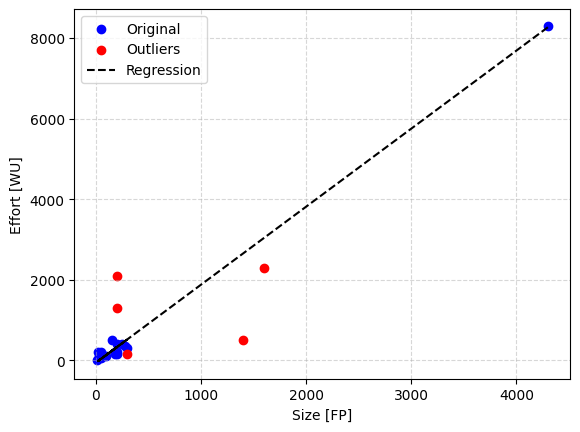

Regression equation : 

<IPython.core.display.Math object>

In [28]:
def generate_plot_1():

  # Get the original data 
  x_original, y_original = get_data()

  # Remove outliers and build model
  x_clean, y_clean, x_outliers, y_outliers, model_no_outliers = build_model_remove_outliers(x_original, y_original)

  # Get the final model's predictions
  y_pred = model_no_outliers.predict(x_clean)

  # Create plots
  plt.scatter(x_clean, y_clean, color='b')
  plt.scatter(x_outliers, y_outliers, color='r')
  plt.plot(x_clean, y_pred, '--k')

  # Add axis labels
  plt.xlabel('Size [FP]')
  plt.ylabel('Effort [WU]')

  # Add grid lines
  plt.grid(True, linestyle='--', alpha=0.5)

  # Add legend
  plt.legend(('Original', 'Outliers', 'Regression'))

  # Show plot
  plt.show()

  # Show regression equation
  print('Regression equation : ', end='')
  slope, intercept = model_get_slope_intercept(model_no_outliers)
  display(Math(r'\hat{y} = ' + f'{slope:.2}x{intercept:.2f}'))

generate_plot_1()

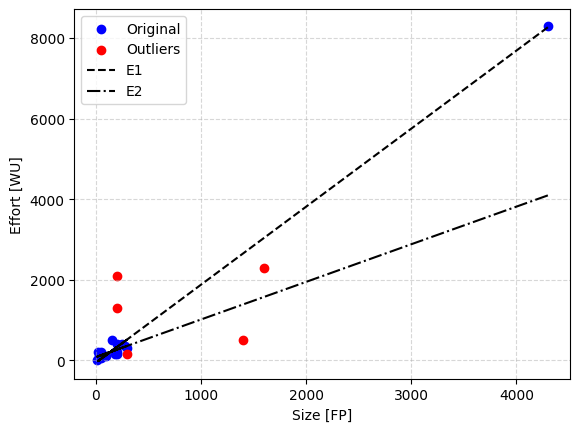

In [24]:

# Get the original data 
x_original, y_original = get_data()

# Remove outliers and build model
x_clean, y_clean, x_outliers, y_outliers, model_no_outliers = build_model_remove_outliers(x_original, y_original)

# Remove the so-called outlier @ x = 4200
i_effort_max = np.argmax(y_clean)

x_removed_rightmost = np.copy(x_clean)
y_removed_rightmost = np.copy(y_clean)

x_removed_rightmost = np.delete(x_removed_rightmost, i_effort_max).reshape(-1, 1)
y_removed_rightmost = np.delete(y_removed_rightmost, i_effort_max).reshape(-1, 1)

model_removed_rightmost = LinearRegression().fit(x_removed_rightmost, y_removed_rightmost)

y_removed_rightmost_pred = model_removed_rightmost.predict(x_removed_rightmost)

# Create plots
plt.scatter(x_clean, y_clean, color='b')
plt.scatter(x_outliers, y_outliers, color='r')
plt.plot(x_clean, y_pred, '--k')
plt.plot(x_clean, model_removed_rightmost.predict(x_clean), '-.k')

# Add axis labels
plt.xlabel('Size [FP]')
plt.ylabel('Effort [WU]')

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Add legend
plt.legend(('Original', 'Outliers', 'E1', 'E2'))

# Show plot
plt.show()

In [ ]:
# Show removed outliers
xx = list(map(int, x_outliers))
yy = list(map(int, y_outliers))

for xx_, yy_ in zip(xx, yy):
  print((xx_, yy_))

print(model_removed_rightmost.intercept_)
print(model_removed_rightmost.coef_[0])

In [ ]:
import scipy.stats as stats

idx = np.argsort(x_removed_rightmost, axis=0)

x_removed_rightmost = x_removed_rightmost[idx].reshape(-1, 1)
y_removed_rightmost = y_removed_rightmost[idx].reshape(-1, 1)
y_removed_rightmost_pred = y_removed_rightmost_pred[idx].reshape(-1, 1)

n = len(x_removed_rightmost)

residuals = y_removed_rightmost - y_removed_rightmost_pred
se = np.sqrt(np.sum(residuals ** 2) / (n - 2))

alpha = 0.05
t_value = stats.t.ppf(1 - alpha / 2, n - 2)
ci = t_value * se * np.sqrt(1 + 1 / n + (x_removed_rightmost - np.mean(x_removed_rightmost)) ** 2 / np.sum((x_removed_rightmost - np.mean(x_removed_rightmost)) ** 2))

lower_ci = y_removed_rightmost_pred - ci
upper_ci = y_removed_rightmost_pred + ci

# Create plots
plt.scatter(x_removed_rightmost, y_removed_rightmost, color='b')
plt.plot(x_removed_rightmost, y_removed_rightmost_pred, 'k')
plt.plot(x_removed_rightmost, upper_ci, 'k--')
plt.plot(x_removed_rightmost, lower_ci, 'k--')
plt.fill_between(x_removed_rightmost.reshape(-1), lower_ci.reshape(-1), upper_ci.reshape(-1), alpha=0.2)

# Add axis labels
plt.xlabel('Size [FP]')
plt.ylabel('Effort [WU]')

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Add legend
plt.legend(('Sanitized data', 'Regression', '95% CI'))

plt.show()

In [ ]:
print(plt.style.available)